In [146]:
import pandas as pd

train_h = pd.read_csv("data/train_h_final.csv")
train_no_ads = pd.read_csv("data/train_no_ads_final.csv")

## Basic Data Cleaning

In [147]:
print(f"columns in h-ads dataset before: {train_h.shape[1]}")
print(f"columns in no-ads dataset before: {train_no_ads.shape[1]}")
print(f"rows in h-ads dataset before: {train_h.shape[0]}")
print(f"rows in no-ads dataset before: {train_no_ads.shape[0]}")

# get features with all NaN values
h_nan_cols = train_h.columns[train_h.isna().all()].tolist()
no_ads_nan_cols = train_no_ads.columns[train_no_ads.isna().all()].tolist()

# get features with all 0 values
h_numeric_cols = train_h.select_dtypes(include='number')
h_zero_cols = h_numeric_cols.columns[h_numeric_cols.eq(0).all()]

no_ads_num_cols = train_no_ads.select_dtypes(include='number')
no_ads_zero_cols = no_ads_num_cols.columns[no_ads_num_cols.eq(0).all()]

print("----")
print("Columns with all NaN values in h-ads dataset:", h_nan_cols)
print("Columns with all NaN values in no-ads dataset:", no_ads_nan_cols)
print("Columns with all 0 values in h-ads dataset:", h_zero_cols)
print("Columns with all 0 values in no-ads dataset:", no_ads_zero_cols)

# drop bad columns and rows
train_h = train_h.drop(columns=h_nan_cols).drop(columns=h_zero_cols).dropna(subset=['structure']).reset_index(drop=True)
train_no_ads = train_no_ads.drop(columns=no_ads_nan_cols).drop(columns=no_ads_zero_cols).dropna(subset=['structure']).reset_index(drop=True)

print("----")
print(f"columns in h-ads dataset after cleaning: {train_h.shape[1]}")
print(f"columns in no-ads dataset after cleaning: {train_no_ads.shape[1]}")

print(f"rows in h-ads dataset after cleaning: {train_h.shape[0]}")
print(f"rows in no-ads dataset after cleaning: {train_no_ads.shape[0]}")

columns in h-ads dataset before: 488
columns in no-ads dataset before: 488
rows in h-ads dataset before: 1605
rows in no-ads dataset before: 14646
----
Columns with all NaN values in h-ads dataset: []
Columns with all NaN values in no-ads dataset: []
Columns with all 0 values in h-ads dataset: Index(['MagpieData minimum NdValence', 'MagpieData minimum NfValence',
       'MagpieData minimum NsUnfilled', 'MagpieData minimum NdUnfilled',
       'MagpieData minimum NfUnfilled', 'MagpieData mode NfUnfilled',
       'MagpieData minimum GSbandgap', 'MagpieData mode GSbandgap',
       'MagpieData minimum GSmagmom'],
      dtype='object')
Columns with all 0 values in no-ads dataset: Index(['MagpieData minimum NdValence', 'MagpieData minimum NfValence',
       'MagpieData minimum NsUnfilled', 'MagpieData minimum NdUnfilled',
       'MagpieData minimum NfUnfilled', 'MagpieData minimum GSbandgap',
       'MagpieData minimum GSmagmom'],
      dtype='object')
----
columns in h-ads dataset after clea

## Step-by-Step Correlation Analysis

It is necessary to perform correlation analysis on each group of features, because we have so many total features.

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# define some helper functions to compute corr matrix and highly correlated pairs
def get_corr_mat(df, show_high_corr_pairs=False, threshold=0.9):
    corr_mat = df.corr().abs()
    upper_tri = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool)) 
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(upper_tri, cmap='coolwarm', center=0, vmin=-1, vmax=1, square=True)
    plt.show()

    if show_high_corr_pairs:
        high_corr_pairs = []
        for column in upper_tri.columns:
            for row in upper_tri.index:
                if abs(upper_tri.loc[row, column]) > threshold:
                    high_corr_pairs.append((row, column, upper_tri.loc[row, column]))

        # Convert the list of pairs to a DataFrame for better readability
        high_corr_df = pd.DataFrame(high_corr_pairs, columns=["Feature 1", "Feature 2", "Correlation"])

        # Sort by absolute correlation value for better inspection
        high_corr_df = high_corr_df.sort_values(by="Correlation", key=abs, ascending=False)

        return high_corr_df

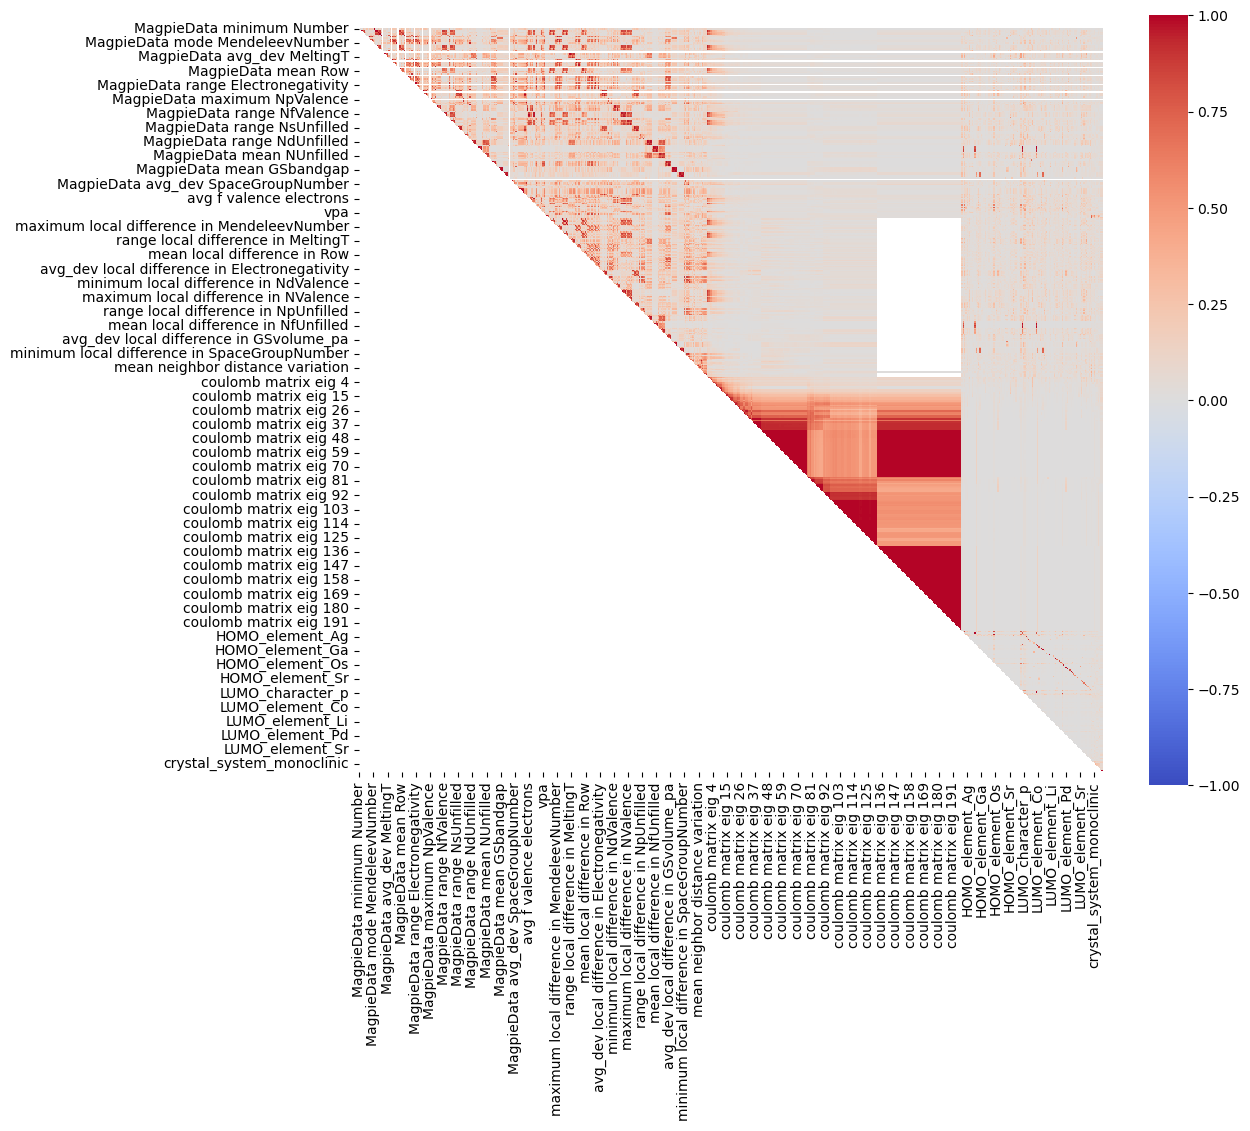

In [149]:
# drop non-numeric columns
train_h_X = train_h.drop(columns=['bulk_id', 'bulk_symbols', 'y_relaxed', 'structure'])

# hot-encode categorical features
encoded_train_h_X = pd.get_dummies(train_h_X)

get_corr_mat(encoded_train_h_X)

## Check Coloum Matrix Features

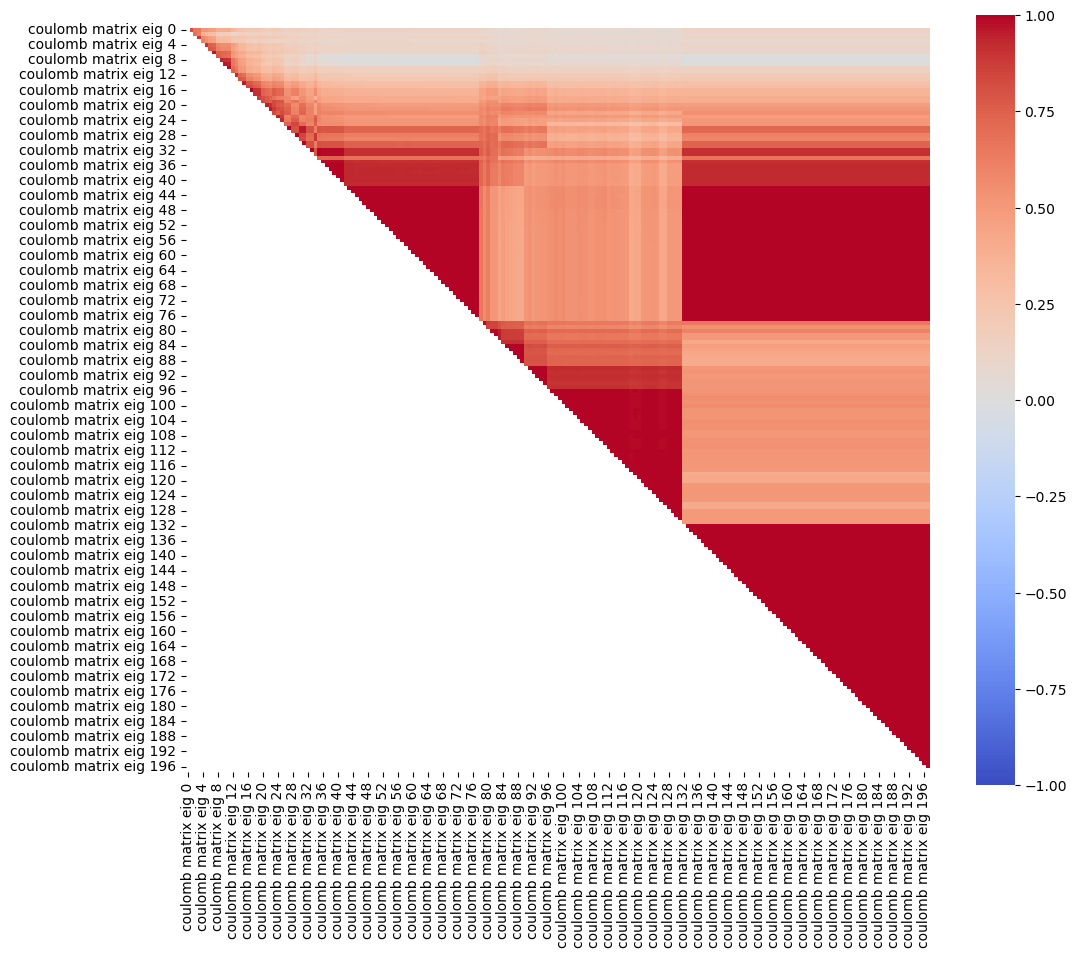

In [150]:
cm_cols = [c for c in train_h.columns if "coulomb matrix eig" in c]
get_corr_mat(train_h[cm_cols])

In [151]:
# drop all coulomb matrix features
# maybe keep some?
encoded_train_h_X = encoded_train_h_X.drop(columns=[c for c in train_h.columns if "coulomb matrix eig" in c]).reset_index(drop=True)

## Check HOMO/LUMO Features

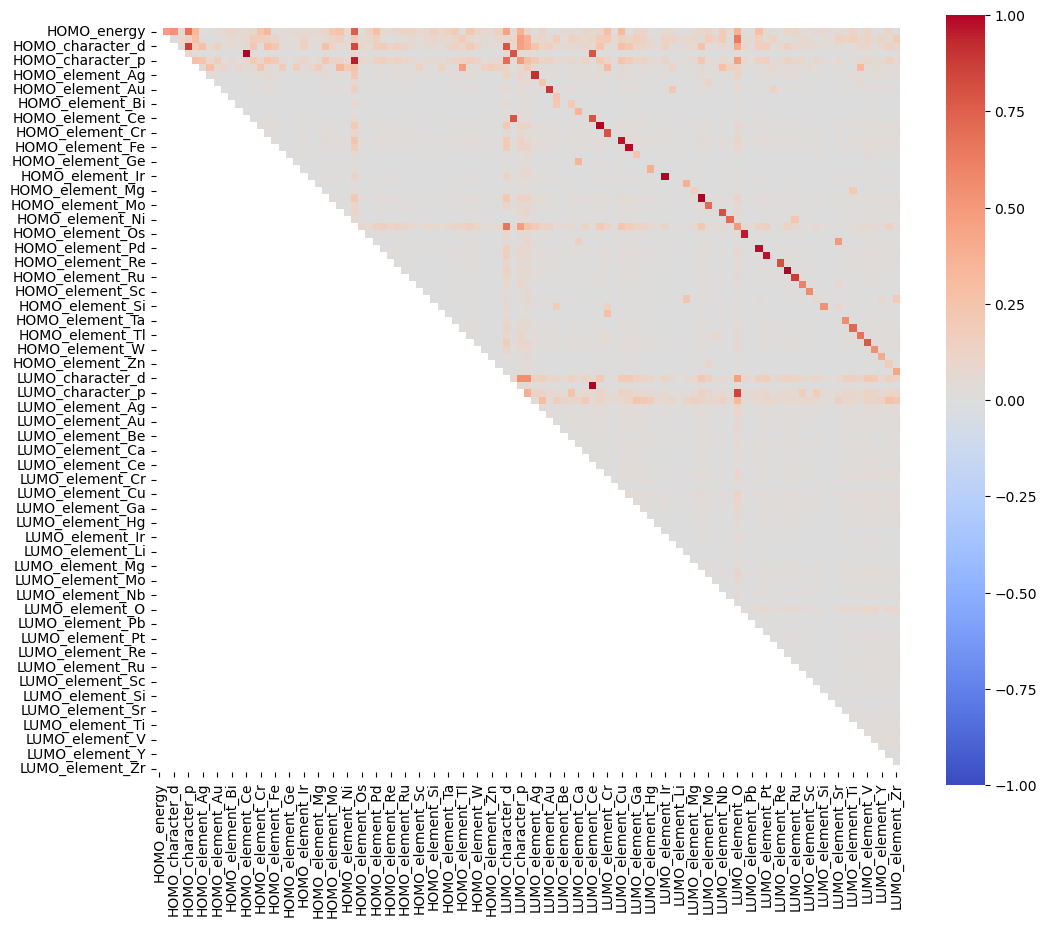

In [152]:
# compute corr matrix
get_corr_mat(encoded_train_h_X[[c for c in encoded_train_h_X.columns if "LUMO" in c or "HOMO" in c]])

HOMO and LUMO columns are almost identical, drop one set

In [153]:
encoded_train_h_X = encoded_train_h_X.drop(columns=[c for c in encoded_train_h_X.columns if "HOMO" in c]).reset_index(drop=True)

## Check MagpieData features

MagpieData gives:
- mode
- mean
- max 
- min
- range
- std dev
- mean local difference
- max local difference
- min local difference
- range local difference
- mean local difference
- avg dev local difference

Check each of these separately and remove highly-correlated pairs

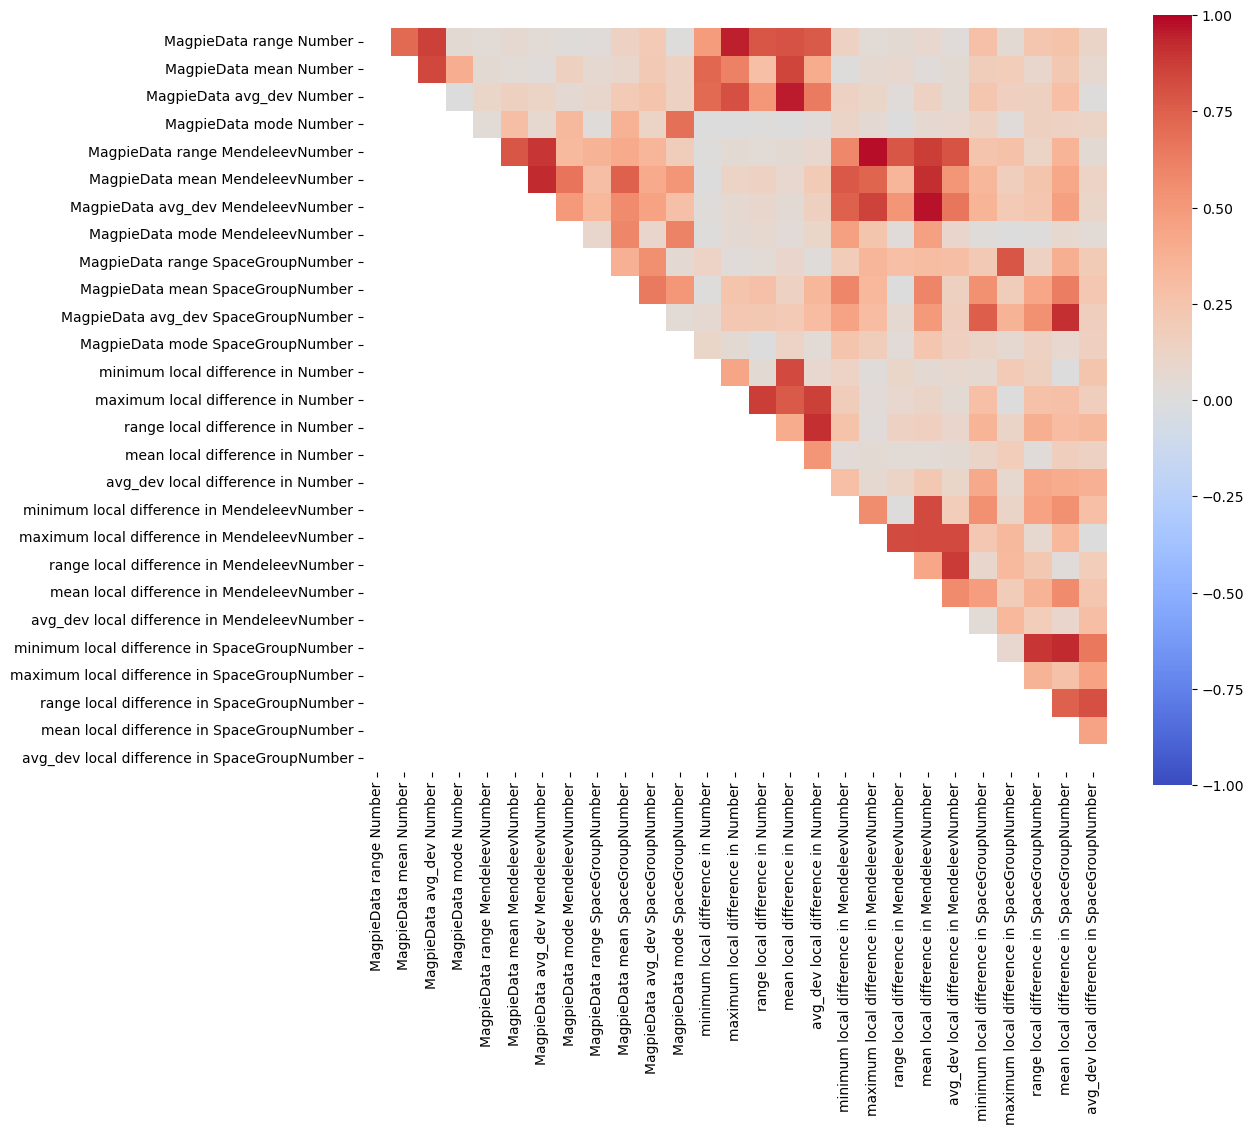

,Feature 1,Feature 2,Correlation
4,MagpieData range MendeleevNumber,maximum local difference in MendeleevNumber,0.979364
6,MagpieData avg_dev MendeleevNumber,mean local difference in MendeleevNumber,0.973659
2,MagpieData avg_dev Number,mean local difference in Number,0.954584
1,MagpieData range Number,maximum local difference in Number,0.948418
8,minimum local difference in SpaceGroupNumber,mean local difference in SpaceGroupNumber,0.925123
0,MagpieData mean MendeleevNumber,MagpieData avg_dev MendeleevNumber,0.924943
5,MagpieData mean MendeleevNumber,mean local difference in MendeleevNumber,0.916059
7,MagpieData avg_dev SpaceGroupNumber,mean local difference in SpaceGroupNumber,0.912813
3,range local difference in Number,avg_dev local difference in Number,0.911068


In [182]:
get_corr_mat(encoded_train_h_X[[c for c in encoded_train_h_X.columns if "Number" in c]], True)

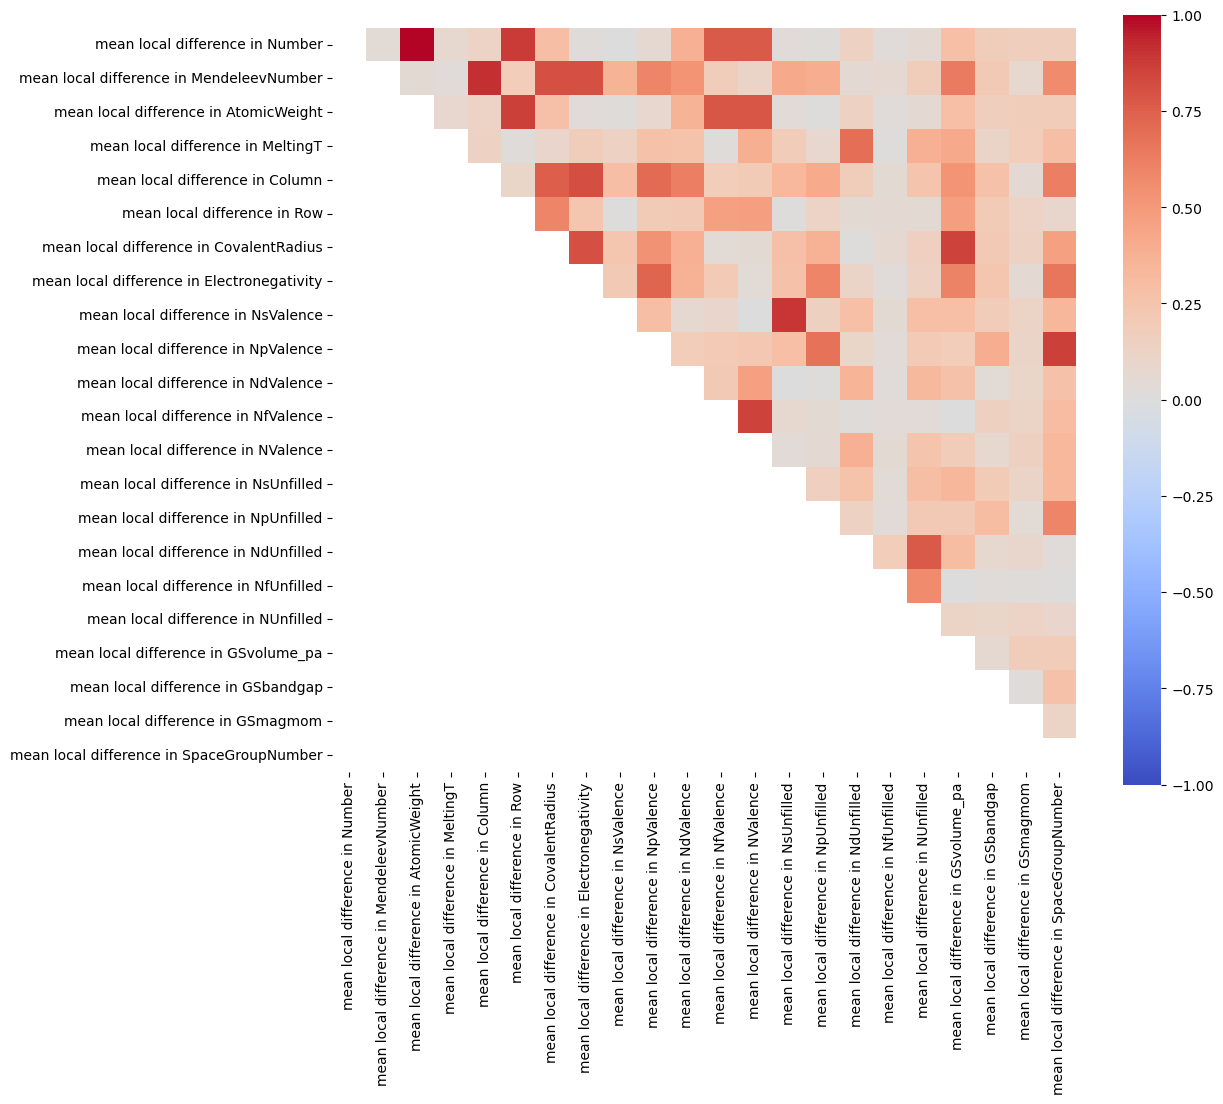

,Feature 1,Feature 2,Correlation
0,mean local difference in Number,mean local difference in AtomicWeight,0.998826
1,mean local difference in MendeleevNumber,mean local difference in Column,0.908520
9,mean local difference in NsValence,mean local difference in NsUnfilled,0.897564
2,mean local difference in Number,mean local difference in Row,0.880714
3,mean local difference in AtomicWeight,mean local difference in Row,0.866557
11,mean local difference in NpValence,mean local difference in SpaceGroupNumber,0.865544
10,mean local difference in CovalentRadius,mean local difference in GSvolume_pa,0.856040
8,mean local difference in NfValence,mean local difference in NValence,0.855381
6,mean local difference in Column,mean local difference in Electronegativity,0.818191
5,mean local difference in MendeleevNumber,mean local difference in Electronegativity,0.810306


In [172]:
# encoded_train_h_X = encoded_train_h_X.drop(
#     columns=[c for c in encoded_train_h_X.columns if "MagpieData maximum" in c or "MagpieData minimum" in c]).reset_index(drop=True)

get_corr_mat(encoded_train_h_X[[c for c in encoded_train_h_X.columns if "mean local difference" in c]], True, 0.8)